Data Dictionary
Variable	Definition	Key
survival 	Survival 	0 = No, 1 = Yes
pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
sex 	Sex 	
Age 	Age in years 	
sibsp 	# of siblings / spouses aboard the Titanic 	
parch 	# of parents / children aboard the Titanic 	
ticket 	Ticket number 	
fare 	Passenger fare 	
cabin 	Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
%matplotlib inline

import matplotlib
import pandas as pd
import xgboost as xgb
import numpy as np
import scipy.sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

/home/uasa/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
directory_path = '/home/uasa/data/titanic/'

In [3]:
ports = {'C':1, 'Q':2, 'S':3, '0':3}
sexes = {'male':1, 'female':2}
ticket_class = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, '0':0}
columns = ['Name', 'Ticket', 'PassengerId']

In [4]:
def get_class(y):
    if type(y) == float:
        return y
    ticket = y.split(' ', 1)
    return ticket_class[ticket[0][0]]

# Two ways to represent our data - sparse matrix (libSVM) and numpy array

# The first one - sparse matrix

In [5]:
data = pd.read_csv(directory_path + 'train.csv').drop(columns, 1).fillna('0')
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22,1,0,7.2500,0,S
1,1,1,female,38,1,0,71.2833,C85,C
2,1,3,female,26,0,0,7.9250,0,S
3,1,1,female,35,1,0,53.1000,C123,S
4,0,3,male,35,0,0,8.0500,0,S


In [6]:
data['Cabin'] = data['Cabin'].map(lambda x: get_class(x), 1)
data['Sex'].replace(sexes, inplace = True)
data['Embarked'].replace(ports, inplace = True)
print(len(data))
matrix = data.as_matrix()
data[:10]

891


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22,1,0,7.2500,0,3
1,1,1,2,38,1,0,71.2833,3,1
2,1,3,2,26,0,0,7.9250,0,3
3,1,1,2,35,1,0,53.1000,3,3
4,0,3,1,35,0,0,8.0500,0,3
5,0,3,1,0,0,0,8.4583,0,2
6,0,1,1,54,0,0,51.8625,5,3
7,0,3,1,2,3,1,21.0750,0,3
8,1,3,2,27,0,2,11.1333,0,3
9,1,2,2,14,1,0,30.0708,0,1


### Split training data to new train-test sets 0.8 - 0.2

In [7]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(data, test_size = 0.2)

### Creating sparce matrix files

In [8]:
from sklearn.datasets import dump_svmlight_file

In [9]:
target = train['Survived']
train = train.drop('Survived', 1)
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
135,2,1,23,0,0,15.0458,0,1
441,3,1,20,0,0,9.5000,0,3
47,3,2,0,0,0,7.7500,0,2
880,2,2,25,0,1,26.0000,0,3
80,3,1,22,0,0,9.0000,0,3


In [10]:
dump_svmlight_file(train.as_matrix(), target.as_matrix(), 'train.libsvm')

In [11]:
target = test['Survived']
test = test.drop('Survived', 1)
dump_svmlight_file(test.as_matrix(), target.as_matrix(), 'test.libsvm')


### Loading libSVM-files

In [12]:
xg_train = xgb.DMatrix('train.libsvm')
xg_test = xgb.DMatrix('test.libsvm')

In [13]:
print(xg_train.num_col(), xg_test.num_col())

(8L, 8L)


# Second one - lets try to inpute missing variables

In [14]:
train_data = pd.read_csv(directory_path + 'train.csv').drop(['PassengerId', 'Name', 'Ticket'], 1)
test_data = pd.read_csv(directory_path + 'test.csv').drop(['PassengerId', 'Name', 'Ticket'], 1)
whole_data = train_data.append(test_data)
print(len(train_data), "+", len(test_data), "=", len(whole_data))
whole_data.tail(20)

(891, '+', 418, '=', 1309)


,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
398,22.0,NaN,S,7.7750,0,3,male,0,NaN
399,31.0,NaN,Q,7.7333,0,3,male,0,NaN
400,30.0,C7,S,164.8667,0,1,female,0,NaN
401,38.0,NaN,S,21.0000,0,2,male,1,NaN
402,22.0,NaN,C,59.4000,1,1,female,0,NaN
403,17.0,NaN,S,47.1000,0,1,male,0,NaN
404,43.0,D40,C,27.7208,0,1,male,1,NaN
405,20.0,D38,C,13.8625,0,2,male,0,NaN
406,23.0,NaN,S,10.5000,0,2,male,1,NaN
407,50.0,C80,C,211.5000,1,1,male,1,NaN


In [15]:
non_missing_data = whole_data.dropna()
print(len(non_missing_data))
non_missing_data.head()

183


,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
1,38.0,C85,C,71.2833,0,1,female,1,1.0
3,35.0,C123,S,53.1000,0,1,female,1,1.0
6,54.0,E46,S,51.8625,0,1,male,0,0.0
10,4.0,G6,S,16.7000,1,3,female,1,1.0
11,58.0,C103,S,26.5500,0,1,female,0,1.0


### Which columns contain missing values?

In [16]:
train_data.columns[pd.isnull(train_data).sum() > 0].tolist()

['Age', 'Cabin', 'Embarked']

In [17]:
#missing age
print(len(train_data[pd.isnull(train_data['Age'])]))

177


In [18]:
#Missing embarked
print(len(train_data[pd.isnull(train_data['Embarked'])]))

2


## First way to do this - guessing those missing values by another present

## It can be done by applying some machine learning technique - from very simple (linear interpolation) to very complex (xgboost)

### Lets divide whole dataset by missing cabin values

In [19]:
cabin = whole_data.loc[pd.notnull(whole_data['Cabin'])]
missing_cabin = whole_data.loc[pd.isnull(whole_data['Cabin'])]
print(len(missing_cabin), len(cabin))

(1014, 295)


### 1014 to 295, is there any benefit of using something like xboost on such data?
#### We can delete it instead

In [20]:
#whole_data['Deck'] = whole_data['Cabin'].apply(lambda x: get_class(x))
whole_data.drop('Cabin', axis=1, inplace = True)
whole_data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,0,3,male,1,0.0
1,38.0,C,71.2833,0,1,female,1,1.0
2,26.0,S,7.9250,0,3,female,0,1.0
3,35.0,S,53.1000,0,1,female,1,1.0
4,35.0,S,8.0500,0,3,male,0,0.0


### We can get somewhat resembling values using linear interpolation from pandas

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c465b3e50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4c462840d0>]], dtype=object)

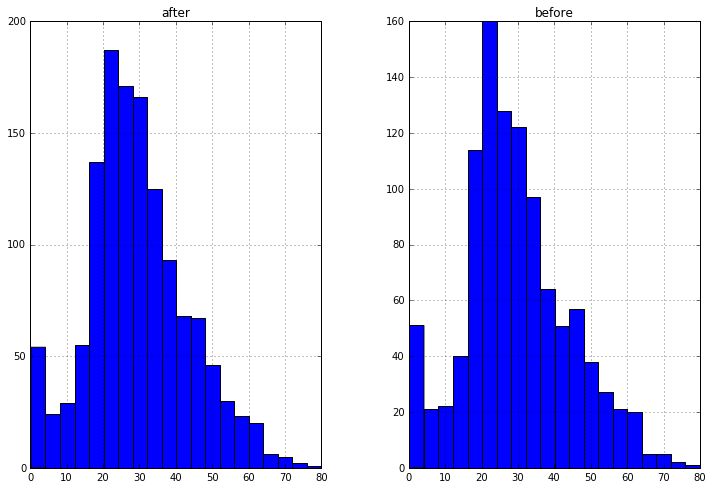

In [21]:
missing_data = whole_data['Age']
filled_data = missing_data.interpolate()
age_difference = pd.DataFrame({'before':missing_data, 'after':filled_data})
age_difference.hist(bins=20, figsize = (12, 8))

### Continuing with linear interpolation.

In [22]:
whole_data['Age'] = whole_data['Age'].interpolate()
whole_data.head(10)

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,0,3,male,1,0.0
1,38.0,C,71.2833,0,1,female,1,1.0
2,26.0,S,7.9250,0,3,female,0,1.0
3,35.0,S,53.1000,0,1,female,1,1.0
4,35.0,S,8.0500,0,3,male,0,0.0
5,44.5,Q,8.4583,0,3,male,0,0.0
6,54.0,S,51.8625,0,1,male,0,0.0
7,2.0,S,21.0750,1,3,male,3,0.0
8,27.0,S,11.1333,2,3,female,0,1.0
9,14.0,C,30.0708,0,2,female,1,1.0


In [23]:
whole_data['Embarked'].fillna(0, inplace = True)
whole_data['Embarked'].replace(ports, inplace = True)
whole_data['Sex'].replace(sexes, inplace = True)
whole_data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,3,7.2500,0,3,1,1,0.0
1,38.0,1,71.2833,0,1,2,1,1.0
2,26.0,3,7.9250,0,3,2,0,1.0
3,35.0,3,53.1000,0,1,2,1,1.0
4,35.0,3,8.0500,0,3,1,0,0.0


In [24]:
train_data = whole_data[pd.notnull(whole_data['Survived'])]
test_data = whole_data[pd.isnull(whole_data['Survived'])]
print(len(train_data), len(test_data))

(891, 418)


In [25]:
train_data.columns.tolist()

['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived']

In [29]:
test_data = test_data.drop('Survived', 1)
test_data.columns.tolist()

['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']

In [30]:
labels = [x for x in range(1,7)]

In [31]:
train, test = train_test_split(train_data, test_size = 0.2)
train_X = train.drop('Survived', 1).as_matrix() 
test_X = test.drop('Survived', 1).as_matrix()
train_y = train['Survived'].as_matrix()

# XGBoost binary logistic

In [32]:
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
#param['objective'] = 'multi:softmax'
param['objective'] = 'binary:logistic'
# scale weight of positive examples
param['eta'] = 0.1
param['lambda'] = 0.08
param['alpha'] = 0.08
param['gamma'] = 0.08
param['max_depth'] = 3
#param['max_delta_step'] = 1
param['subsample'] = 0.5
param['min_child_weight'] = 1
param['silent'] = 1
param['nthread'] = 8
#param['num_class'] = 2

#watchlist = [ (train_X,'train'), (test_X, 'test') ]
#num_round = 500
#bst = xgb.train(param, train_X, num_round, watchlist )

In [33]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.05, nthread=8, silent=0).fit(train_X, train_y)
predictions = gbm.predict(test_X)
final_pred = gbm.predict(test_data.as_matrix())

In [35]:
test_data = pd.read_csv(directory_path + 'test.csv')

In [38]:
submission = pd.DataFrame({ 'PassengerId': test_data['PassengerId'],
                            'Survived': final_pred })
submission.to_csv("submission.csv", index=False, float_format='%.0f')

# Final score  = 0.76